In [409]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import catboost as cat
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from dateutil.easter import easter
from datetime import timedelta
import lightgbm as lgb
import optuna
import warnings
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")


color_pal = sns.color_palette()

In [344]:
data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "test.parquet")
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
test_data["date"] = pd.to_datetime(test_data["date"])
test_data = test_data.set_index("date")

In [345]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
date,,,,,,,,,,
2020-09-01 02:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
2020-09-01 03:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
2020-09-01 04:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
2020-09-01 15:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
2020-09-01 18:00:00,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [346]:
class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1),
        Holiday("Labour Day", month=5, day=1),
        Holiday("Victory in Europe Day", month=5, day=8),
        Holiday("Bastille Day", month=7, day=14),
        Holiday("Assumption of Mary", month=8, day=15),
        Holiday("All Saints' Day", month=11, day=1),
        Holiday("Armistice Day", month=11, day=11),
        Holiday("Christmas Day", month=12, day=25),
    ]

    @staticmethod
    def easter_related_holidays(year):
        easter_sunday = easter(year)
        return [
            (easter_sunday + timedelta(days=1), "Easter Monday"),
            (easter_sunday + timedelta(days=39), "Ascension Day"),
        ]

In [347]:
def cyclical_encode(df, column, max_value):
    df[column + "_sin"] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + "_cos"] = np.cos(2 * np.pi * df[column] / max_value)
    return df

In [348]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear

    # Boolean for weekends
    df["is_weekend"] = df["dayofweek"].isin([5, 6])

    # cyclical
    df = cyclical_encode(df, "hour", 24)
    df = cyclical_encode(df, "dayofweek", 7)

    # Boolean for holidays
    cal = FrenchHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    easter_holidays = []
    for year in range(df.index.year.min(), df.index.year.max() + 1):
        for date, _ in FrenchHolidayCalendar.easter_related_holidays(year):
            easter_holidays.append(date)
    holidays = holidays.union(pd.to_datetime(easter_holidays))
    df["is_holiday"] = df.index.isin(holidays)

    # Lockdown periods
    lockdowns = {
        "lockdown_1": ("2020-03-17", "2020-05-10"),
        "lockdown_2": ("2020-10-28", "2020-12-01"),
        # with curfew from 7 PM to 6 AM
        "lockdown_3_1": ("2021-04-03", "2021-05-18"),
        # with curfew from 9 PM to 6 AM
        "lockdown_3_2": ("2021-05-19", "2021-06-08"),
        # with curfew from 11 PM to 6 AM
        "lockdown_3_3": ("2021-06-09", "2021-06-29"),
    }
    for lockdown, (start_date, end_date) in lockdowns.items():
        mask = (df.index >= start_date) & (df.index <= end_date)
        df[lockdown] = mask

    return df

In [349]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 02:00:00 to 2021-08-09 17:00:00
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   counter_installation_date  455163 non-null  datetime64[ns]
 6   counter_technical_id       455163 non-null  category      
 7   latitude                   455163 non-null  float64       
 8   longitude                  455163 non-null  float64       
 9   log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(4), int64(1)
memory usage: 26.1 MB


In [350]:
train = data[["counter_name", "log_bike_count"]]
test = test_data[["counter_name", "log_bike_count"]]

In [351]:
train = create_features(train)

In [352]:
test = create_features(test)

In [353]:
train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'is_weekend', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'is_holiday', 'lockdown_1',
       'lockdown_2', 'lockdown_3_1', 'lockdown_3_2', 'lockdown_3_3'],
      dtype='object')

In [301]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [302]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [225]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [226]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_feature)],
    remainder="passthrough",
)

In [227]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", reg)])

In [228]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'counter_technical_id'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categ...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [229]:
y_pred_xgb = pipeline.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Test: 0.4213214886499577


In [230]:
xgb_model = pipeline.named_steps["model"]

xgb_model.feature_importances_

array([0.00076883, 0.00047264, 0.00581698, 0.00029617, 0.00212538,
       0.00153523, 0.00221045, 0.00742345, 0.00224215, 0.01608515,
       0.06087166, 0.00115311, 0.0082392 , 0.00029855, 0.00358773,
       0.00101061, 0.00190123, 0.00070486, 0.00150595, 0.00423788,
       0.03300705, 0.00361235, 0.00634791, 0.00046837, 0.00165798,
       0.00063637, 0.00202507, 0.00146017, 0.01424686, 0.00107515,
       0.00032017, 0.00082523, 0.00063093, 0.00245907, 0.00763956,
       0.00365831, 0.00056961, 0.0004552 , 0.00105525, 0.00078731,
       0.00147105, 0.00435819, 0.00706708, 0.00954156, 0.00593443,
       0.00050036, 0.00399154, 0.00458813, 0.00174834, 0.00040822,
       0.00090495, 0.0073606 , 0.00064145, 0.01475752, 0.00449818,
       0.00291922, 0.00045782, 0.00178766, 0.        , 0.02907013,
       0.00541193, 0.00020741, 0.00239733, 0.01047893, 0.        ,
       0.        , 0.        , 0.02656515, 0.00503733, 0.01754842,
       0.01237245, 0.00033971, 0.0890001 , 0.00667045, 0.03159

In [239]:
X_train_encoded = pd.get_dummies(
    X_train,
    columns=["counter_name", "counter_technical_id"],
    prefix=["encoded_counter", "encoded_tech"],
)
X_test_encoded = pd.get_dummies(
    X_test,
    columns=["counter_name", "counter_technical_id"],
    prefix=["encoded_counter", "encoded_tech"],
)

In [240]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [241]:
reg.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_train_encoded, y_train), (X_test_encoded, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.23858	validation_1-rmse:2.40079
[10]	validation_0-rmse:0.71584	validation_1-rmse:0.65765
[20]	validation_0-rmse:0.57967	validation_1-rmse:0.53242
[30]	validation_0-rmse:0.53174	validation_1-rmse:0.49330
[40]	validation_0-rmse:0.49793	validation_1-rmse:0.47098
[50]	validation_0-rmse:0.47975	validation_1-rmse:0.45525
[60]	validation_0-rmse:0.45429	validation_1-rmse:0.45053
[70]	validation_0-rmse:0.44031	validation_1-rmse:0.44343
[80]	validation_0-rmse:0.43015	validation_1-rmse:0.44128
[90]	validation_0-rmse:0.41922	validation_1-rmse:0.43604
[100]	validation_0-rmse:0.41037	validation_1-rmse:0.43513
[110]	validation_0-rmse:0.40137	validation_1-rmse:0.43083
[120]	validation_0-rmse:0.39539	validation_1-rmse:0.42929
[130]	validation_0-rmse:0.38913	validation_1-rmse:0.42687
[140]	validation_0-rmse:0.38383	validation_1-rmse:0.42438
[150]	validation_0-rmse:0.38000	validation_1-rmse:0.42597
[153]	validation_0-rmse:0.37893	validation_1-rmse:0.42512


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [242]:
y_hat_xgb = reg.predict(X_train_encoded)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

XGB Train: 0.3822908419455515


In [243]:
y_pred_xgb = reg.predict(X_test_encoded)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Test: 0.42380724675821113


In [244]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["Importance"],
)

<AxesSubplot: title={'center': 'Feature Importances'}>

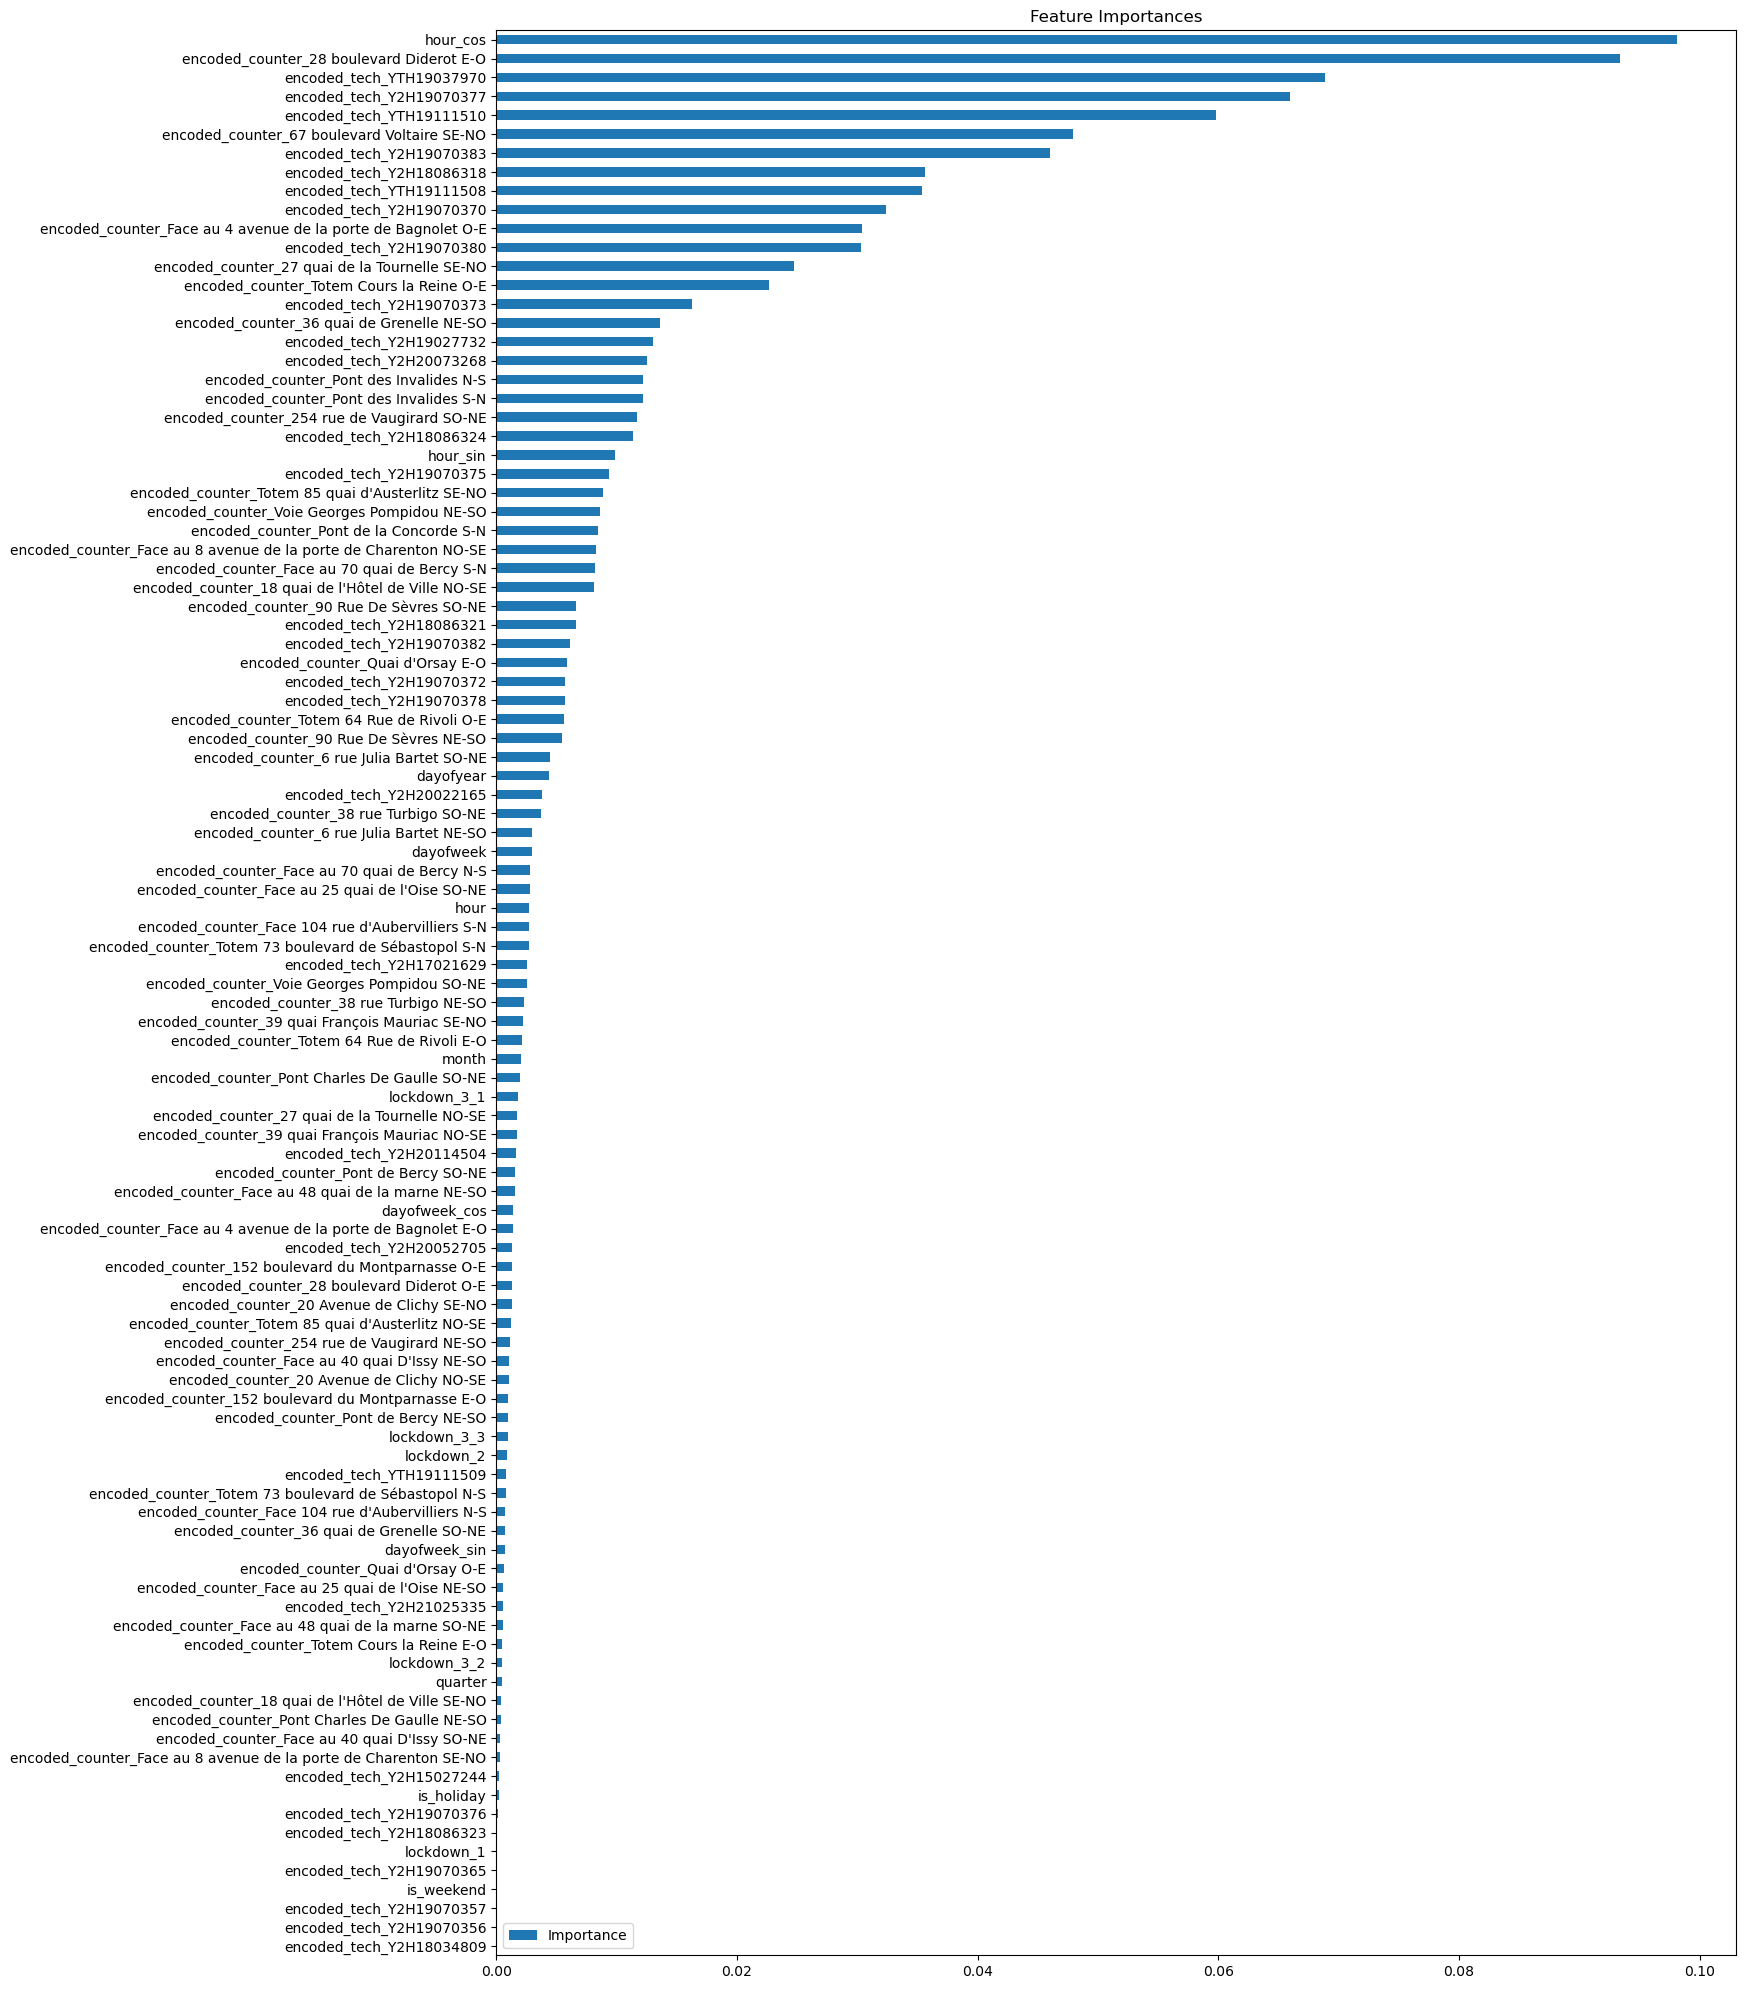

In [245]:
fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances", figsize=(16, 25)
)

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 02:00:00 to 2021-08-09 17:00:00
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   counter_name    455163 non-null  category
 1   log_bike_count  455163 non-null  float64 
 2   hour            455163 non-null  int64   
 3   dayofweek       455163 non-null  int64   
 4   quarter         455163 non-null  int64   
 5   month           455163 non-null  int64   
 6   dayofyear       455163 non-null  int64   
 7   is_weekend      455163 non-null  int32   
 8   hour_sin        455163 non-null  float64 
 9   hour_cos        455163 non-null  float64 
 10  dayofweek_sin   455163 non-null  float64 
 11  dayofweek_cos   455163 non-null  float64 
 12  is_holiday      455163 non-null  int32   
 13  lockdown_1      455163 non-null  int32   
 14  lockdown_2      455163 non-null  int32   
 15  lockdown_3_1    455163 non-null  int32   
 16  lock

In [303]:
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)


for column in boolean_columns:
    test[column] = test[column].astype(int)

In [304]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455163 entries, 2020-09-01 02:00:00 to 2021-08-09 17:00:00
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   counter_name          455163 non-null  category
 1   counter_technical_id  455163 non-null  category
 2   log_bike_count        455163 non-null  float64 
 3   hour                  455163 non-null  int64   
 4   dayofweek             455163 non-null  int64   
 5   quarter               455163 non-null  int64   
 6   month                 455163 non-null  int64   
 7   dayofyear             455163 non-null  int64   
 8   is_weekend            455163 non-null  int32   
 9   hour_sin              455163 non-null  float64 
 10  hour_cos              455163 non-null  float64 
 11  dayofweek_sin         455163 non-null  float64 
 12  dayofweek_cos         455163 non-null  float64 
 13  is_holiday            455163 non-null  int32   
 14  lo

In [305]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [307]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

In [308]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21313	validation_1-rmse:2.36521


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.57312	validation_1-rmse:0.53580
[20]	validation_0-rmse:0.48553	validation_1-rmse:0.45986
[30]	validation_0-rmse:0.45149	validation_1-rmse:0.44651
[40]	validation_0-rmse:0.43159	validation_1-rmse:0.43939
[50]	validation_0-rmse:0.41607	validation_1-rmse:0.43538
[60]	validation_0-rmse:0.40526	validation_1-rmse:0.43029
[70]	validation_0-rmse:0.39500	validation_1-rmse:0.43156
[75]	validation_0-rmse:0.39077	validation_1-rmse:0.43041


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [309]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.39934484816890625
XGB Test: 0.4288531805244451


<AxesSubplot: title={'center': 'Feature Importances'}>

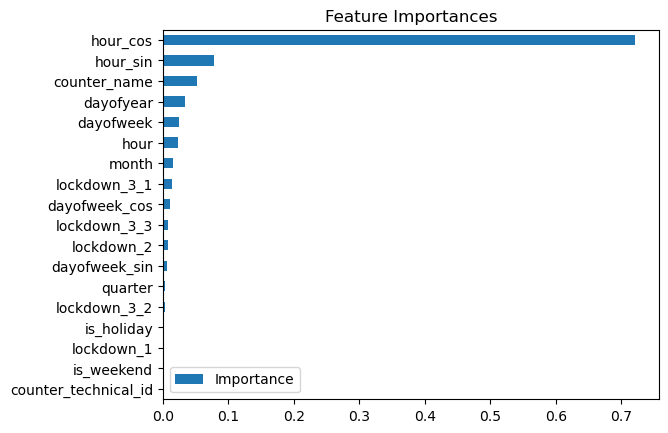

In [311]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [260]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.721425
hour_sin,0.077310
counter_name,0.052627
dayofyear,0.033743
dayofweek,0.024453
hour,0.022485
month,0.015594
lockdown_3_1,0.013538
dayofweek_cos,0.010955
lockdown_3_3,0.007845


In [261]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [262]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [263]:
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, enable_categorical=True)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21313	validation_1-rmse:2.36521


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.57067	validation_1-rmse:0.53574
[20]	validation_0-rmse:0.48549	validation_1-rmse:0.46170
[30]	validation_0-rmse:0.44980	validation_1-rmse:0.44363
[40]	validation_0-rmse:0.43007	validation_1-rmse:0.43562
[50]	validation_0-rmse:0.41509	validation_1-rmse:0.43188
[60]	validation_0-rmse:0.40307	validation_1-rmse:0.42731
[70]	validation_0-rmse:0.39334	validation_1-rmse:0.42332
[80]	validation_0-rmse:0.38694	validation_1-rmse:0.42226
[90]	validation_0-rmse:0.38116	validation_1-rmse:0.42240
[94]	validation_0-rmse:0.37795	validation_1-rmse:0.42694


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [264]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.3850702806455573
XGB Test: 0.4218602311746617


<AxesSubplot: title={'center': 'Feature Importances'}>

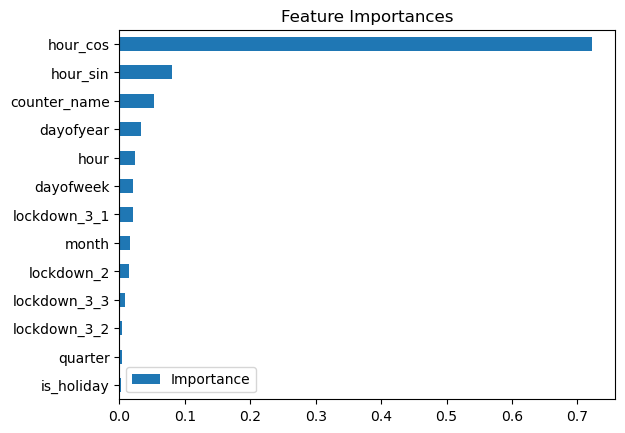

In [265]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [266]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.722166
hour_sin,0.079598
counter_name,0.053243
dayofyear,0.032916
hour,0.023411
dayofweek,0.021274
lockdown_3_1,0.020464
month,0.015527
lockdown_2,0.013892
lockdown_3_3,0.007895


In [267]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)

In [268]:
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5240483	test: 1.5238900	test1: 1.3446539	best: 1.3446539 (0)	total: 160ms	remaining: 2m 40s
10:	learn: 0.8718688	test: 0.8695631	test1: 0.7449179	best: 0.7449179 (10)	total: 1.3s	remaining: 1m 56s
20:	learn: 0.7551270	test: 0.7518565	test1: 0.6449331	best: 0.6449331 (20)	total: 2.4s	remaining: 1m 52s
30:	learn: 0.7099454	test: 0.7069503	test1: 0.6119232	best: 0.6119232 (30)	total: 3.76s	remaining: 1m 57s
40:	learn: 0.6875225	test: 0.6843947	test1: 0.5967792	best: 0.5967792 (40)	total: 5.09s	remaining: 1m 59s
50:	learn: 0.6629032	test: 0.6596363	test1: 0.5856663	best: 0.5856663 (50)	total: 6.45s	remaining: 1m 59s
60:	learn: 0.6435045	test: 0.6398954	test1: 0.5611265	best: 0.5611265 (60)	total: 7.71s	remaining: 1m 58s
70:	learn: 0.6266952	test: 0.6228592	test1: 0.5495154	best: 0.5495154 (70)	total: 9s	remaining: 1m 57s
80:	learn: 0.6125140	test: 0.6082996	test1: 0.5390151	best: 0.5390151 (80)	total: 10.3s	remaining: 1m 56s
90:	learn: 0.5995150	te

In [269]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.42416886423483796
CAT Test: 0.41768004289565547


<AxesSubplot: title={'center': 'Feature Importances'}>

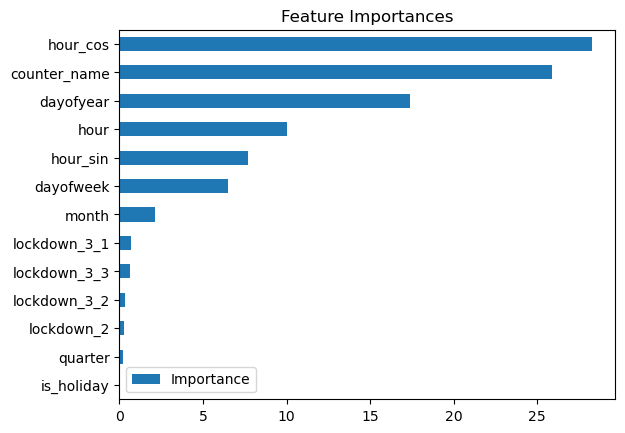

In [124]:
fi = pd.DataFrame(
    data=cat_reg.feature_importances_,
    index=features,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [112]:
weather_data = pd.read_csv("data/external_data_cleaned.csv")

In [117]:
weather_data_hourly.head()

,t,rr1,rr3,rr6,ff,raf10,rafper,u,vv,n,cl,cm,ch,day,week,precipitation,cloudy_day
date,,,,,,,,,,,,,,,,,
2020-09-01 00:00:00,285.75,0.0,0.0,0.0,1.6,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,2020-09-01,36,0,0
2020-09-01 01:00:00,285.75,0.0,0.0,0.0,1.6,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,2020-09-01,36,0,0
2020-09-01 02:00:00,285.75,0.0,0.0,0.0,1.6,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,2020-09-01,36,0,0
2020-09-01 03:00:00,283.95,0.0,0.0,0.0,1.1,1.5,1.5,88,25000,0.0,30.0,20.0,10.0,2020-09-01,36,0,0
2020-09-01 04:00:00,283.95,0.0,0.0,0.0,1.1,1.5,1.5,88,25000,0.0,30.0,20.0,10.0,2020-09-01,36,0,0


In [113]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data.set_index("date", inplace=True)

In [115]:
weather_data_hourly = weather_data.resample("H").ffill()

In [118]:
weather_data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9973 entries, 2020-09-01 00:00:00 to 2021-10-21 12:00:00
Freq: H
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   t              9973 non-null   float64
 1   rr1            9973 non-null   float64
 2   rr3            9973 non-null   float64
 3   rr6            9973 non-null   float64
 4   ff             9973 non-null   float64
 5   raf10          9973 non-null   float64
 6   rafper         9973 non-null   float64
 7   u              9973 non-null   int64  
 8   vv             9973 non-null   int64  
 9   n              9973 non-null   float64
 10  cl             9973 non-null   float64
 11  cm             9973 non-null   float64
 12  ch             9973 non-null   float64
 13  day            9973 non-null   object 
 14  week           9973 non-null   int64  
 15  precipitation  9973 non-null   int64  
 16  cloudy_day     9973 non-null   int64  
dtypes: float

In [136]:
weather_data_hourly = weather_data_hourly.drop(columns=["week", "day"])

In [138]:
combined_train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'is_weekend', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'is_holiday', 'lockdown_1',
       'lockdown_2', 'lockdown_3_1', 'lockdown_3_2', 'lockdown_3_3', 't',
       'rr1', 'rr3', 'rr6', 'ff', 'raf10', 'rafper', 'u', 'vv', 'n', 'cl',
       'cm', 'ch', 'precipitation', 'cloudy_day'],
      dtype='object')

In [137]:
# Merge train and weather_data_hourly on their DateTimeIndex
combined_train = train.merge(
    weather_data_hourly, left_index=True, right_index=True, how="left"
)
combined_test = test.merge(
    weather_data_hourly, left_index=True, right_index=True, how="left"
)

In [163]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "ff",
    "raf10",
    "rafper",
    "u",
    "vv",
    "n",
    "cl",
    "cm",
    "ch",
    "precipitation",
    "cloudy_day",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [164]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [312]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21313	validation_1-rmse:2.36521


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.57312	validation_1-rmse:0.53580
[20]	validation_0-rmse:0.48553	validation_1-rmse:0.45986
[30]	validation_0-rmse:0.45149	validation_1-rmse:0.44651
[40]	validation_0-rmse:0.43159	validation_1-rmse:0.43939
[50]	validation_0-rmse:0.41607	validation_1-rmse:0.43538
[60]	validation_0-rmse:0.40526	validation_1-rmse:0.43029
[70]	validation_0-rmse:0.39500	validation_1-rmse:0.43156
[75]	validation_0-rmse:0.39077	validation_1-rmse:0.43041


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [313]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.39934484816890625
XGB Test: 0.4288531805244451


<AxesSubplot: title={'center': 'Feature Importances'}>

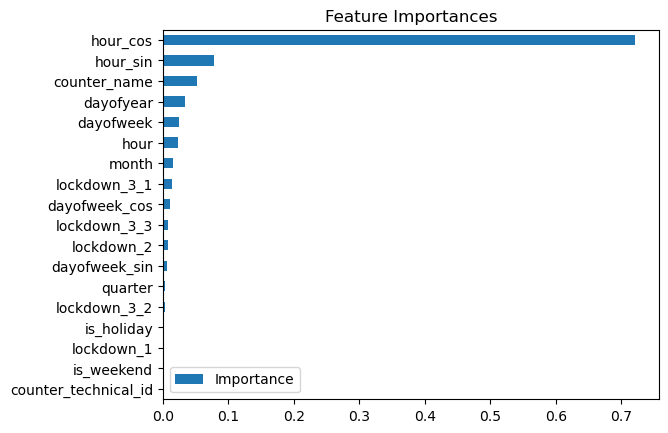

In [314]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [315]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5300503	test: 1.5300496	test1: 1.3467889	best: 1.3467889 (0)	total: 185ms	remaining: 3m 4s
10:	learn: 0.8869673	test: 0.8858114	test1: 0.7529795	best: 0.7529795 (10)	total: 1.44s	remaining: 2m 9s
20:	learn: 0.7633599	test: 0.7616755	test1: 0.6411361	best: 0.6411361 (20)	total: 2.59s	remaining: 2m
30:	learn: 0.7190439	test: 0.7168246	test1: 0.6059789	best: 0.6047855 (29)	total: 3.9s	remaining: 2m 1s
40:	learn: 0.6877413	test: 0.6852865	test1: 0.5880210	best: 0.5880210 (40)	total: 5.14s	remaining: 2m
50:	learn: 0.6661424	test: 0.6634513	test1: 0.5743371	best: 0.5743371 (50)	total: 6.59s	remaining: 2m 2s
60:	learn: 0.6473914	test: 0.6443486	test1: 0.5562542	best: 0.5562542 (60)	total: 8.15s	remaining: 2m 5s
70:	learn: 0.6288552	test: 0.6243297	test1: 0.5528777	best: 0.5523403 (67)	total: 9.71s	remaining: 2m 7s
80:	learn: 0.5976751	test: 0.5929656	test1: 0.5396285	best: 0.5396285 (80)	total: 11.1s	remaining: 2m 6s
90:	learn: 0.5870148	test: 0.58209

In [316]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.45502551308928385
CAT Test: 0.4427993967026589


In [317]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "ff",
    "raf10",
    "rafper",
    "u",
    "vv",
    "n",
    "cl",
    "cm",
    "ch",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [318]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [319]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21259	validation_1-rmse:2.34779


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.57838	validation_1-rmse:0.52187
[20]	validation_0-rmse:0.48361	validation_1-rmse:0.48571
[30]	validation_0-rmse:0.44812	validation_1-rmse:0.45934
[40]	validation_0-rmse:0.43198	validation_1-rmse:0.45387
[50]	validation_0-rmse:0.41551	validation_1-rmse:0.44730
[60]	validation_0-rmse:0.40733	validation_1-rmse:0.44569
[70]	validation_0-rmse:0.40196	validation_1-rmse:0.44577
[80]	validation_0-rmse:0.39543	validation_1-rmse:0.44328
[90]	validation_0-rmse:0.38825	validation_1-rmse:0.43307
[100]	validation_0-rmse:0.38459	validation_1-rmse:0.43350
[101]	validation_0-rmse:0.38425	validation_1-rmse:0.43351


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [320]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.3879546941579545
XGB Test: 0.4329167584282352


<AxesSubplot: title={'center': 'Feature Importances'}>

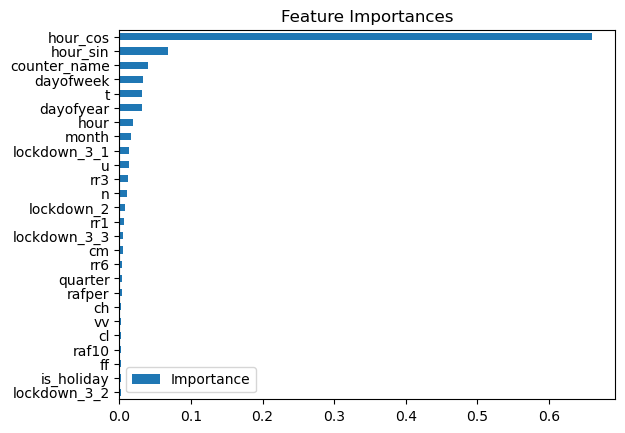

In [321]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

In [323]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.660092
hour_sin,0.068271
counter_name,0.040457
dayofweek,0.033138
t,0.031354
dayofyear,0.030973
hour,0.018581
month,0.016703
lockdown_3_1,0.013891
u,0.013345


In [324]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5216706	test: 1.5214992	test1: 1.3403676	best: 1.3403676 (0)	total: 145ms	remaining: 2m 24s
10:	learn: 0.8717100	test: 0.8705528	test1: 0.7359135	best: 0.7359135 (10)	total: 1.31s	remaining: 1m 57s
20:	learn: 0.7551061	test: 0.7529661	test1: 0.6385808	best: 0.6385808 (20)	total: 2.53s	remaining: 1m 58s
30:	learn: 0.7117715	test: 0.7091129	test1: 0.6110916	best: 0.6110916 (30)	total: 3.93s	remaining: 2m 2s
40:	learn: 0.6853975	test: 0.6826854	test1: 0.6009477	best: 0.6009477 (40)	total: 5.39s	remaining: 2m 6s
50:	learn: 0.6709669	test: 0.6678923	test1: 0.5892208	best: 0.5892208 (50)	total: 6.83s	remaining: 2m 7s
60:	learn: 0.6468248	test: 0.6434478	test1: 0.5762285	best: 0.5762285 (60)	total: 8.26s	remaining: 2m 7s
70:	learn: 0.6308379	test: 0.6271757	test1: 0.5638533	best: 0.5638533 (70)	total: 9.62s	remaining: 2m 5s
80:	learn: 0.6170187	test: 0.6128723	test1: 0.5590397	best: 0.5589494 (76)	total: 11s	remaining: 2m 5s
90:	learn: 0.5924775	test:

In [325]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.4664098208471778
CAT Test: 0.47189471662101234


In [326]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "is_holiday",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "ff",
    "raf10",
    "u",
    "n",
    "cm",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [327]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [328]:
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, enable_categorical=True)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21259	validation_1-rmse:2.34779


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.58123	validation_1-rmse:0.52335
[20]	validation_0-rmse:0.48206	validation_1-rmse:0.45688
[30]	validation_0-rmse:0.44969	validation_1-rmse:0.44497
[40]	validation_0-rmse:0.43138	validation_1-rmse:0.44430
[50]	validation_0-rmse:0.41696	validation_1-rmse:0.43953
[60]	validation_0-rmse:0.40919	validation_1-rmse:0.43912
[70]	validation_0-rmse:0.40117	validation_1-rmse:0.43671
[80]	validation_0-rmse:0.39430	validation_1-rmse:0.43502
[90]	validation_0-rmse:0.38810	validation_1-rmse:0.43168
[99]	validation_0-rmse:0.38408	validation_1-rmse:0.43212


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [329]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.38809603490016187
XGB Test: 0.4316781868576021


<AxesSubplot: title={'center': 'Feature Importances XGBoost'}>

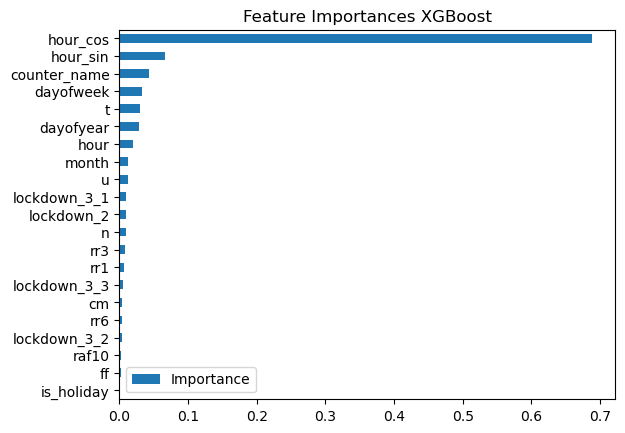

In [330]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost")

In [331]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.688043
hour_sin,0.066494
counter_name,0.043047
dayofweek,0.032484
t,0.030432
dayofyear,0.028579
hour,0.019895
month,0.012625
u,0.012084
lockdown_3_1,0.010203


In [193]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5220463	test: 1.3430557	best: 1.3430557 (0)	total: 116ms	remaining: 1m 55s
10:	learn: 0.8780304	test: 0.7374085	best: 0.7374085 (10)	total: 1.04s	remaining: 1m 34s
20:	learn: 0.7576744	test: 0.6388983	best: 0.6388983 (20)	total: 2.03s	remaining: 1m 34s
30:	learn: 0.7136969	test: 0.6081556	best: 0.6081556 (30)	total: 3.04s	remaining: 1m 35s
40:	learn: 0.6858204	test: 0.6022997	best: 0.6022997 (40)	total: 4.14s	remaining: 1m 36s
50:	learn: 0.6680675	test: 0.5936416	best: 0.5936416 (50)	total: 5.25s	remaining: 1m 37s
60:	learn: 0.6385274	test: 0.5787073	best: 0.5787073 (60)	total: 6.31s	remaining: 1m 37s
70:	learn: 0.6241468	test: 0.5696798	best: 0.5694641 (69)	total: 7.47s	remaining: 1m 37s
80:	learn: 0.6025016	test: 0.5595020	best: 0.5595020 (80)	total: 8.62s	remaining: 1m 37s
90:	learn: 0.5889513	test: 0.5549190	best: 0.5549190 (90)	total: 9.7s	remaining: 1m 36s
100:	learn: 0.5760474	test: 0.5403350	best: 0.5403350 (100)	total: 10.8s	remaining:

In [194]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.41169346543866797
CAT Test: 0.43294167313507714


<AxesSubplot: title={'center': 'Feature Importances CATBoost'}>

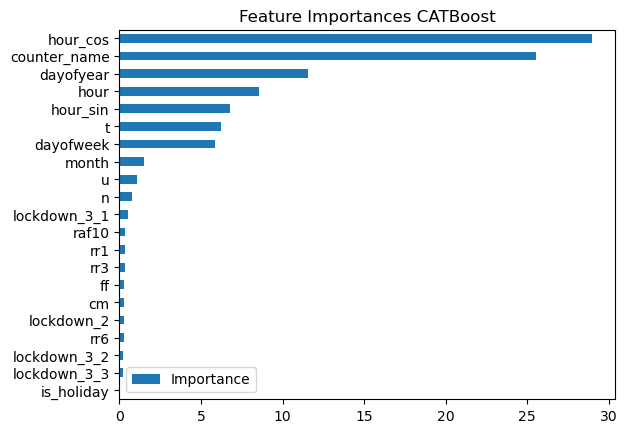

In [202]:
fi = pd.DataFrame(
    data=cat_reg.feature_importances_,
    index=features,
    columns=["Importance"],
)

fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances CATBoost")

In [ ]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "t",
    "rr1",
    "rr3",
    "rr6",
    "raf10",
    "u",
    "n",
    "cm",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [276]:
combined_train["t"].head(20)

date
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
2020-09-01 01:00:00    285.75
Name: t, dtype: float64

In [277]:
combined_train.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,...,raf10,rafper,u,vv,n,cl,cm,ch,precipitation,cloudy_day
date,,,,,,,,,,,,,,,,,,,,,
2020-09-01 01:00:00,28 boulevard Diderot E-O,0.000000,1,1,3,9,245,0,0.258819,0.965926,...,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,0,0
2020-09-01 01:00:00,28 boulevard Diderot O-E,0.693147,1,1,3,9,245,0,0.258819,0.965926,...,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,0,0
2020-09-01 01:00:00,39 quai François Mauriac NO-SE,1.098612,1,1,3,9,245,0,0.258819,0.965926,...,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,0,0
2020-09-01 01:00:00,39 quai François Mauriac SE-NO,0.693147,1,1,3,9,245,0,0.258819,0.965926,...,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,0,0
2020-09-01 01:00:00,18 quai de l'Hôtel de Ville NO-SE,0.000000,1,1,3,9,245,0,0.258819,0.965926,...,2.4,3.1,81,30000,0.0,30.0,20.0,10.0,0,0


# Updated Weather

In [359]:
weather_data = pd.read_csv("data/external_data_cleaned_updated.csv")

In [360]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data.set_index("date", inplace=True)

In [361]:
weather_data_hourly = weather_data.resample("H").ffill()

In [362]:
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)


for column in boolean_columns:
    test[column] = test[column].astype(int)

In [363]:
combined_train = train.merge(
    weather_data_hourly, left_index=True, right_index=True, how="left"
)
combined_test = test.merge(
    weather_data_hourly, left_index=True, right_index=True, how="left"
)

In [364]:
combined_train.columns

Index(['counter_name', 'log_bike_count', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'is_weekend', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'is_holiday', 'lockdown_1',
       'lockdown_2', 'lockdown_3_1', 'lockdown_3_2', 'lockdown_3_3', 'pmer',
       'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2',
       'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'tend24', 'raf10',
       'rafper', 'etat_sol', 'ht_neige', 'ssfrai', 'rr1', 'rr3', 'rr6', 'rr12',
       'rr24', 'nnuage1', 'ctype1', 'hnuage1'],
      dtype='object')

In [365]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "w2",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [366]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [368]:
reg = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, enable_categorical=True)

In [369]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21258	validation_1-rmse:2.34787


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.57992	validation_1-rmse:0.55755
[20]	validation_0-rmse:0.48075	validation_1-rmse:0.47832
[30]	validation_0-rmse:0.45288	validation_1-rmse:0.47225
[40]	validation_0-rmse:0.43489	validation_1-rmse:0.45969
[50]	validation_0-rmse:0.41829	validation_1-rmse:0.45498
[60]	validation_0-rmse:0.41027	validation_1-rmse:0.45289
[70]	validation_0-rmse:0.40039	validation_1-rmse:0.45160
[75]	validation_0-rmse:0.39767	validation_1-rmse:0.45181


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [370]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.40353772924335907
XGB Test: 0.4513233863066848


<AxesSubplot: title={'center': 'Feature Importances XGBoost'}>

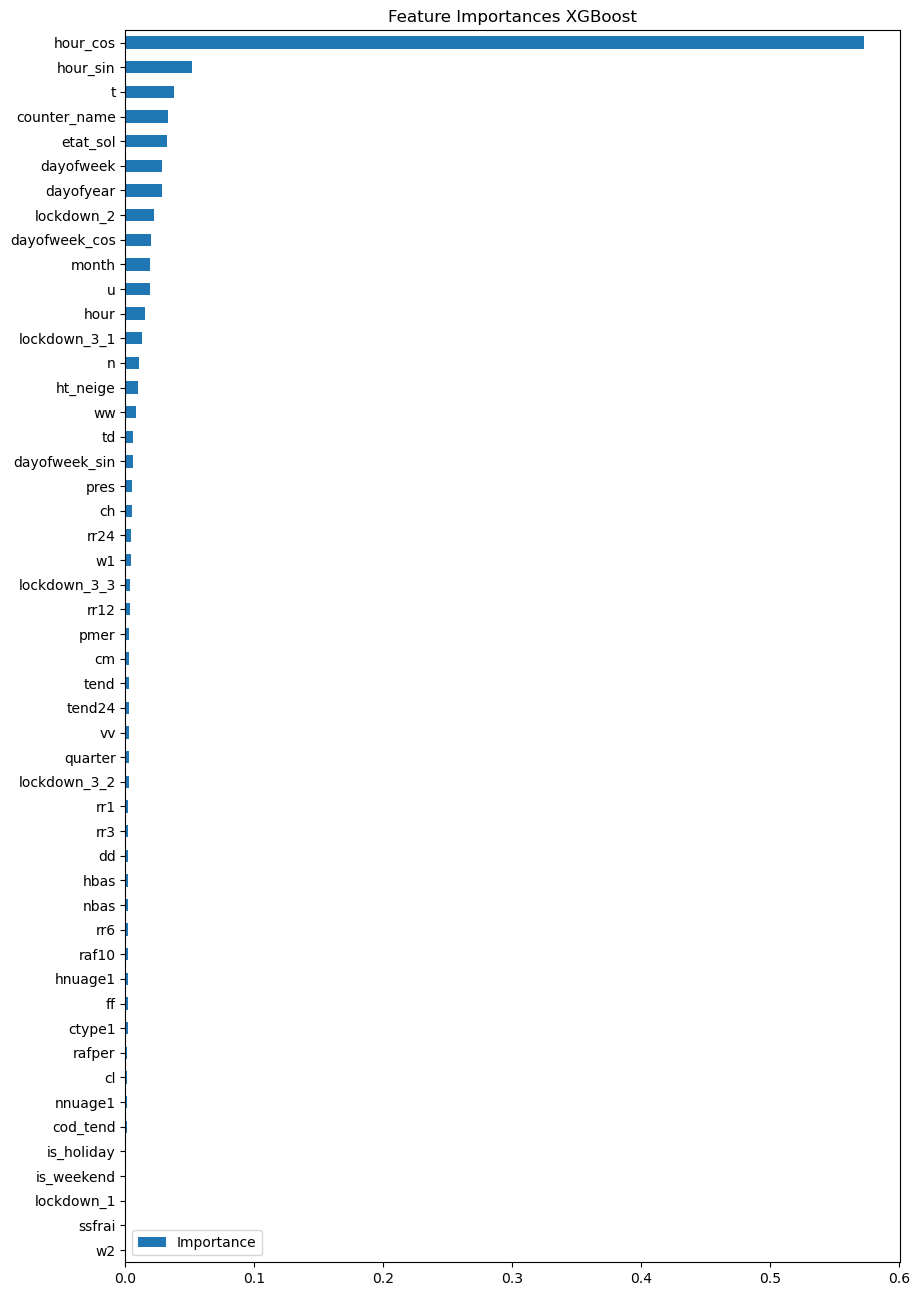

In [373]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [374]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.572561
hour_sin,0.051854
t,0.037416
counter_name,0.033108
etat_sol,0.032090
dayofweek,0.028661
dayofyear,0.027987
lockdown_2,0.022345
dayofweek_cos,0.019777
month,0.018893


In [375]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5221414	test: 1.5219972	test1: 1.3427000	best: 1.3427000 (0)	total: 155ms	remaining: 2m 34s
10:	learn: 0.8737620	test: 0.8729067	test1: 0.7330941	best: 0.7330941 (10)	total: 1.3s	remaining: 1m 57s
20:	learn: 0.7540864	test: 0.7522790	test1: 0.6397102	best: 0.6397102 (20)	total: 2.7s	remaining: 2m 5s
30:	learn: 0.7094142	test: 0.7072504	test1: 0.6066695	best: 0.6066695 (30)	total: 4.11s	remaining: 2m 8s
40:	learn: 0.6730677	test: 0.6701467	test1: 0.5894406	best: 0.5894406 (40)	total: 5.48s	remaining: 2m 8s
50:	learn: 0.6446107	test: 0.6414054	test1: 0.5771210	best: 0.5768400 (49)	total: 6.9s	remaining: 2m 8s
60:	learn: 0.6263203	test: 0.6228861	test1: 0.5632215	best: 0.5632215 (60)	total: 8.34s	remaining: 2m 8s
70:	learn: 0.6110253	test: 0.6071621	test1: 0.5519090	best: 0.5519090 (70)	total: 9.7s	remaining: 2m 6s
80:	learn: 0.5953506	test: 0.5907453	test1: 0.5428905	best: 0.5428905 (80)	total: 11s	remaining: 2m 5s
90:	learn: 0.5833999	test: 0.57

In [376]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.45551638095701197
CAT Test: 0.468459811908399


In [382]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
    "pmer",
    "tend",
    "cod_tend",
    "dd",
    "ff",
    "t",
    "td",
    "u",
    "vv",
    "ww",
    "w1",
    "n",
    "nbas",
    "hbas",
    "cl",
    "cm",
    "ch",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "etat_sol",
    "ht_neige",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "nnuage1",
    "ctype1",
    "hnuage1",
]
target = ["log_bike_count"]
cat_feature = ["counter_name"]

In [383]:
X_train = combined_train[features]
y_train = combined_train[target]
X_test = combined_test[features]
y_test = combined_test[target]

In [384]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21258	validation_1-rmse:2.34787


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.57992	validation_1-rmse:0.55755
[20]	validation_0-rmse:0.48075	validation_1-rmse:0.47832
[30]	validation_0-rmse:0.45288	validation_1-rmse:0.47225
[40]	validation_0-rmse:0.43416	validation_1-rmse:0.45823
[50]	validation_0-rmse:0.42150	validation_1-rmse:0.45550
[60]	validation_0-rmse:0.41062	validation_1-rmse:0.45117
[70]	validation_0-rmse:0.40171	validation_1-rmse:0.44665
[80]	validation_0-rmse:0.39373	validation_1-rmse:0.44612
[90]	validation_0-rmse:0.38947	validation_1-rmse:0.44501
[100]	validation_0-rmse:0.38451	validation_1-rmse:0.43949
[110]	validation_0-rmse:0.37825	validation_1-rmse:0.43896
[117]	validation_0-rmse:0.37567	validation_1-rmse:0.43891


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [390]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

XGB Train: 0.3799935525180389
XGB Test: 0.43704548725301623


<AxesSubplot: title={'center': 'Feature Importances XGBoost'}>

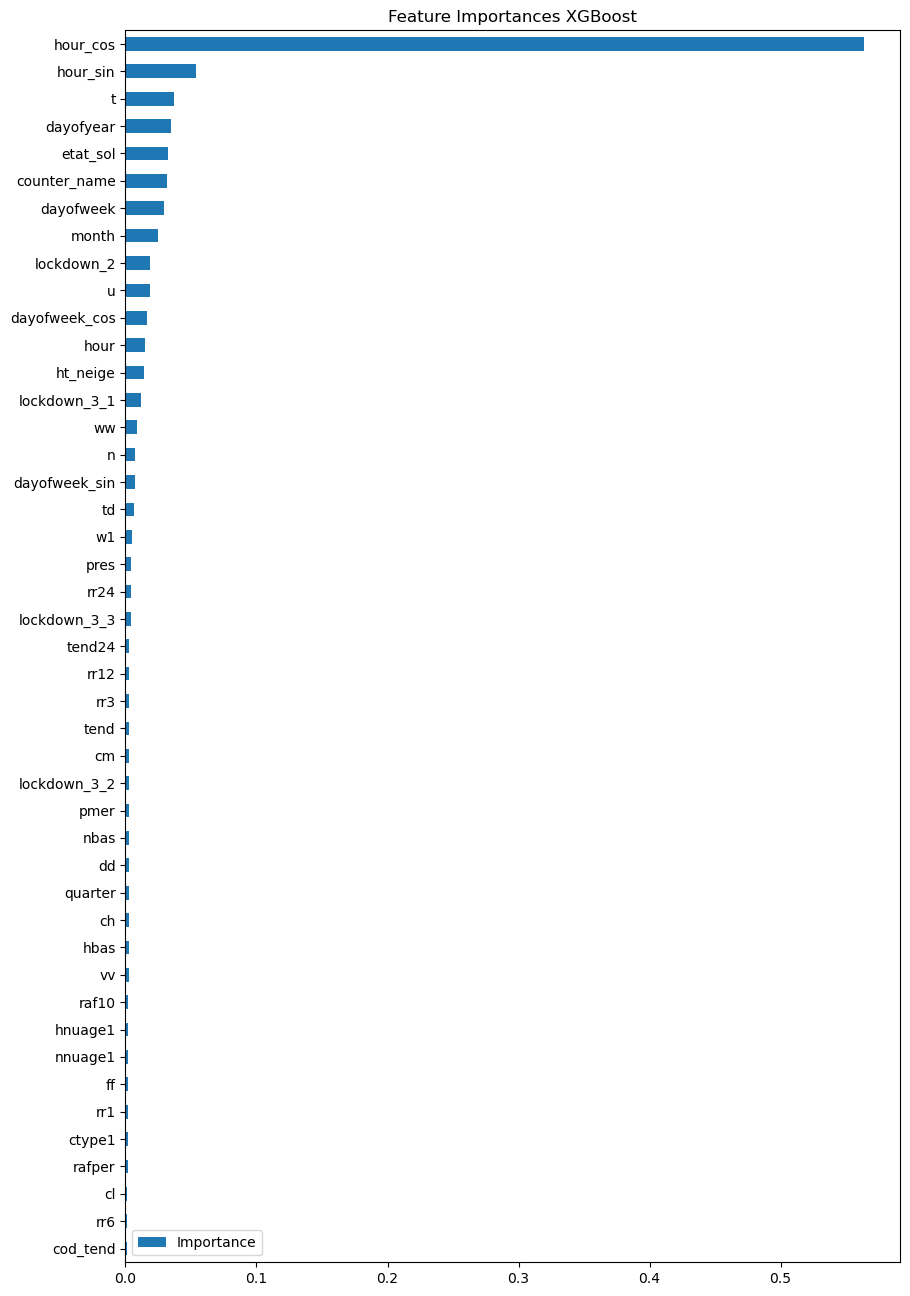

In [386]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

fi.sort_values(by="Importance").plot(
    kind="barh", title="Feature Importances XGBoost", figsize=(10, 16)
)

In [387]:
fi.sort_values(by="Importance", ascending=False)

,Importance
hour_cos,0.563318
hour_sin,0.053606
t,0.037409
dayofyear,0.034853
etat_sol,0.032733
counter_name,0.031643
dayofweek,0.029623
month,0.024815
lockdown_2,0.018626
u,0.018407


In [388]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000, cat_features=cat_feature)
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5224449	test: 1.5222930	test1: 1.3416216	best: 1.3416216 (0)	total: 145ms	remaining: 2m 24s
10:	learn: 0.8725063	test: 0.8710305	test1: 0.7388844	best: 0.7388844 (10)	total: 1.28s	remaining: 1m 54s
20:	learn: 0.7548682	test: 0.7524453	test1: 0.6408916	best: 0.6408916 (20)	total: 2.47s	remaining: 1m 55s
30:	learn: 0.7137316	test: 0.7110841	test1: 0.6056981	best: 0.6056981 (30)	total: 3.75s	remaining: 1m 57s
40:	learn: 0.6694779	test: 0.6659400	test1: 0.5882658	best: 0.5882658 (40)	total: 5.08s	remaining: 1m 58s
50:	learn: 0.6546229	test: 0.6508497	test1: 0.5807069	best: 0.5807069 (50)	total: 6.57s	remaining: 2m 2s
60:	learn: 0.6342528	test: 0.6303827	test1: 0.5682649	best: 0.5682649 (60)	total: 7.97s	remaining: 2m 2s
70:	learn: 0.6219432	test: 0.6173322	test1: 0.5597524	best: 0.5597524 (70)	total: 9.31s	remaining: 2m 1s
80:	learn: 0.6059094	test: 0.6008829	test1: 0.5508633	best: 0.5508633 (80)	total: 10.7s	remaining: 2m 1s
90:	learn: 0.5957348	t

In [389]:
y_hat_cat = cat_reg.predict(X_train)
rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
print("CAT Train:", rmse_cat_train)

y_test_cat = cat_reg.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
print("CAT Test:", rmse_cat_test)

CAT Train: 0.45543679117800295
CAT Test: 0.471083704493645


In [391]:
X_train.shape

(455163, 45)

In [398]:
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feature)

In [399]:
params = {
    "boosting_type": "gbdt",  # Gradient boosting
    "objective": "regression",  # Task is regression
    "metric": {"l2", "l1"},  # Evaluation metrics
    "num_leaves": 31,  # Number of leaves in full tree
    "learning_rate": 0.05,  # Learning rate
    "feature_fraction": 0.9,  # Fraction of features to be used in each iteration
    "bagging_fraction": 0.8,  # Fraction of data to be used in each iteration
    "bagging_freq": 5,  # Frequency for bagging
    "verbose": 10,  # Verbosity of output
}

In [400]:
lgbm = lgb.train(params, d_train, num_boost_round=100)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.826281
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.217882
[LightGBM] [Debug] init for col-wise cost 0.012726 seconds, init for row-wise cost 0.024375 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 455163, number of used features: 45
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 3.048589
[LightGBM] [Debug] Re-bagging, using 364176 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth 

In [401]:
y_pred_lgbm = lgbm.predict(X_test)


rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print("LightGBM Test:", rmse_lgbm)

LightGBM Test: 0.4846795850517754


In [412]:
def objective_xgb(trial):
    # Hyperparameter search space
    params = {
        "tree_method": "hist",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 10.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []  # Store RMSE scores for each fold

    for train_index, val_index in tscv.split(X_train):
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBRegressor(**params, enable_categorical=True)
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False,
        )

        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # Calculate the average RMSE over all folds
    avg_rmse = np.mean(rmse_scores)

    return avg_rmse

In [414]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2023-12-09 19:58:59,745] A new study created in memory with name: no-name-1a27a51f-24b6-4bb3-bb97-b3b9baf0b1f6
[I 2023-12-09 19:59:17,759] Trial 0 finished with value: 1.01040900081888 and parameters: {'lambda': 0.012341138904425302, 'alpha': 0.003111112569500301, 'colsample_bytree': 0.3362188748290469, 'subsample': 0.7122021568172198, 'learning_rate': 0.018583371382175418, 'max_depth': 10, 'min_child_weight': 215}. Best is trial 0 with value: 1.01040900081888.
[I 2023-12-09 19:59:34,310] Trial 1 finished with value: 2.8967682906429717 and parameters: {'lambda': 4.9661783442799964e-05, 'alpha': 0.0037786469441972994, 'colsample_bytree': 0.3812975685236462, 'subsample': 0.7285903053173849, 'learning_rate': 0.00028649046802853496, 'max_depth': 8, 'min_child_weight': 271}. Best is trial 0 with value: 1.01040900081888.
[I 2023-12-09 19:59:48,993] Trial 2 finished with value: 2.675494828217479 and parameters: {'lambda': 2.2311583375446858e-07, 'alpha': 0.0019127213975089143, 'colsample_b

In [416]:
best_params = study_xgb.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'lambda': 5.5163638658795495, 'alpha': 5.722067076221477e-06, 'colsample_bytree': 0.5588623654042607, 'subsample': 0.7939924932498187, 'learning_rate': 0.08132063380230384, 'max_depth': 10, 'min_child_weight': 132}


In [ ]:
best_params = {
    "lambda": 5.5163638658795495,
    "alpha": 5.722067076221477e-06,
    "colsample_bytree": 0.5588623654042607,
    "subsample": 0.7939924932498187,
    "learning_rate": 0.08132063380230384,
    "max_depth": 10,
    "min_child_weight": 132,
}

In [422]:
final_model = xgb.XGBRegressor(
    tree_method="hist", **best_params, enable_categorical=True
)
final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.99695
[10]	validation_0-rmse:1.35993
[20]	validation_0-rmse:0.73068
[30]	validation_0-rmse:0.51924
[40]	validation_0-rmse:0.46712
[50]	validation_0-rmse:0.45413
[60]	validation_0-rmse:0.44429
[70]	validation_0-rmse:0.43302
[80]	validation_0-rmse:0.42799
[90]	validation_0-rmse:0.42621
[99]	validation_0-rmse:0.42227


XGBRegressor(alpha=5.722067076221477e-06, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5588623654042607, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5.5163638658795495,
             learning_rate=0.08132063380230384, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=132, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

In [420]:
y_pred_test = final_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Final Model Test RMSE:", rmse_test)

Final Model Test RMSE: 0.4222693913654174
